# Data and Setup
For this project, our primary dataset will be a dataframe that contains **19095 cities** in the U.S. with a list of variables that characterize certain features for each city. These variables/features include:

* City's Name
* City's State
* City's County
* Latitude Coordinate
* Longitude Coordinate
* Population
* Density
* If Incorporated (if a city is a legitimate city or township)
* If Military (if a town is technically a fort or military base)
* If Capital of State or Nation
* Timezone
* Ranking (1-3, descending in importance with unknown/unstated criteria; more on this later)
* Number of Zip Codes in City
    
Outside of this dataset, we collected satellite images of each U.S. capital from NASA's Earth API to observe changes over time. NASA pre-processes these images so effects like the time of day are minimized. The API is tricky to work with however, since it provides only so many images throughout a year, and only so many of those images contain traces of land, given that clouds tend to fill most of them.


# Objectives

Now that we have our dataset, we would like to ask the following questions about it:

* Are there meaningful correlations between variables in the *us_cities* dataset?
    * Why or why not?
* How do these correlations change when looking at subsets of *us_cities*, such as *capitals*?
* What could be the metric for the *ranking* variable?
* Through satellite image analysis, are there any meaningful correlations with the *capitals* subset? 
    * Could someone implement a very basic model in this manner and yield accurate predictions for population or density? 
    * If not, what could be some causes? If so, could this method be broadened to non-capital cities?

,city,state_id,state,county,lat,long,population,density,military,incorporated,capital,timezone,ranking,zips
0,New York,NY,New York,New York,40.6943,-73.9249,18713220,10715,0,1,0,New_York,1,309
1,Los Angeles,CA,California,Los Angeles,34.1139,-118.4068,12750807,3276,0,1,0,Los_Angeles,1,196
2,Chicago,IL,Illinois,Cook,41.8373,-87.6862,8604203,4574,0,1,0,Chicago,1,85
3,Miami,FL,Florida,Miami-Dade,25.7839,-80.2102,6445545,5019,0,1,0,New_York,1,30
4,Dallas,TX,Texas,Dallas,32.7936,-96.7662,5743938,1526,0,1,0,Chicago,1,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19090,Portage Creek,AK,Alaska,Dillingham,58.9051,-157.6695,3,0,0,0,0,Anchorage,3,1
19091,Gross,NE,Nebraska,Boyd,42.9461,-98.5697,2,6,0,1,0,Chicago,3,1
19092,Lotsee,OK,Oklahoma,Tulsa,36.1334,-96.2091,2,39,0,1,0,Chicago,3,1
19093,The Ranch,MN,Minnesota,Mahnomen,47.3198,-95.6952,2,2,0,1,0,Chicago,3,1


Salt Lake City, 2017 05 01:


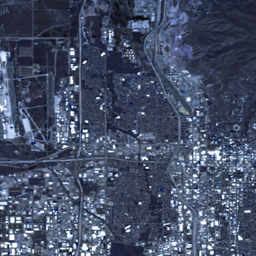

Salt Lake City, 2020 05 01:


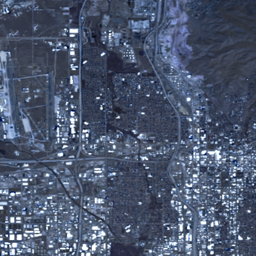

In [1]:
import os, cv2, requests, base64, imageio
from PIL import Image
from io import BytesIO
from IPython.display import display

from sklearn import tree, linear_model, metrics        # linear_model.LinearRegression() for OLS
from sklearn.metrics import homogeneity_score, v_measure_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm     # used statsmodels.formula.api.ols() for OLS

import seaborn as sn
import pandas as pd
import scipy as sc
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

us_cities = pd.read_csv("us_cities_v2.csv")
us_cities['timezone'] = [_[8:] for _ in us_cities['timezone'].values]

capitals = us_cities.loc[us_cities['capital']]
capitals = capitals.reset_index(drop=True)

for _ in ['military', 'incorporated', 'capital']:
    us_cities[_] = pd.DataFrame(1*us_cities[_])
    
incorp = us_cities.loc[us_cities['incorporated']==1]
incorp = incorp.reset_index(drop=True)

display(us_cities)

demo1 = Image.open('_DEMO_Salt_Lake_City_2017_05_01.png')
print('Salt Lake City, 2017 05 01:')
display(demo1.resize([256,256]))

demo2 = Image.open('_DEMO_Salt_Lake_City_2020_05_01.png')
print('Salt Lake City, 2020 05 01:')
display(demo2.resize([256,256]))

Images are stored at a lower resolution than stored above, to reduce net file size and processing time.

**Satellite image retrieval code; it takes appoximately forty minutes to cycle through enough semi-clean images (don't worry, it can't bite now)**

In [2]:
dates = ['2016-05-01', '2019-05-01']
site = "https://api.nasa.gov/planetary/earth/imagery?"
key = "fooTh1s1saFakeKeyForDEmoPurp0s3sfoo"

def fetch_sat_imgs(dates):
    counter = 0
    for date in dates:
        for i, city in capitals.iterrows():
            date_ = date
        
            # Query API for capital image
            url = site + "lon=" + str(city['long']) + "&lat=" + str(city['lat']) + \
                      "&dim=.1&date=" + date + "&api_key=" + api_key
        
            response = requests.get(url)
            print("Ok?",response.ok,'i =',i)
            
            if response.ok:
                img = Image.open(BytesIO(response.content))
                cloudy = is_cloudy(img)
                print(cloudy)
                
                attempts = 0
                while cloudy and attempts <= 4:
                    #NOTE - Selects nearest date
                    date = next_mo(date)
                    url = site + "lon=" + str(city['long']) + "&lat=" + str(city['lat']) + \
                        "&dim=.1&date=" + date + "&api_key=" + key1
                    response = requests.get(url)
                    
                    img = Image.open(BytesIO(response.content))
                    
                    cloudy = is_cloudy(img)
                    attempts += 1
                    
                if response.ok:
                    img = img.resize((32,32))
                    
                    name = '_' + city['city'].replace(' ','_') + '_' + date.replace('-','_') + '.png'
                    #saves images to folder with noramalized name 
                    #img.save(name)
                    date = date_
                    counter += 1
                    
                if attempts > 4:
                    print(city['city'], date)
                    date = date_
                    
def next_mo(date):
    mo = '0' + str(int(date[5:7]) + 1)
    if len(mo) > 2:
        mo = mo[1:]
    date = date[:5] + mo + date[7:]
    return date

def is_cloudy(img):
    #Takes Image object, returns bool if it meets 'cloudy' criteria
    k = 75 #Threshold coeff.
    
    hist = img.histogram()
    Rm = np.mean(hist[:256])
    Gm = np.mean(hist[256:512])
    Bm = np.mean(hist[512:])
    W = [hist[255], hist[511], hist[-1]]
    
    if W[0] > k*Rm or W[1] > k*Gm or W[2] > k*Bm:
        return True
    else:
        return False

# Exploratory Analysis

Description of U.S. Cities Dataset:


,lat,long,population,density,military,incorporated,capital,ranking,zips
count,19095.000000,19095.000000,1.909500e+04,19095.000000,19095.000000,19095.000000,19095.000000,19095.000000,19095.000000
mean,38.343561,-93.287520,1.956564e+04,583.061849,0.004294,0.678293,0.002671,2.928306,1.750039
std,6.322977,16.981737,2.308976e+05,882.553662,0.065392,0.467144,0.051613,0.267946,5.005778
min,17.955900,-176.629500,1.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,34.682900,-99.252750,4.110000e+02,124.000000,0.000000,0.000000,0.000000,3.000000,1.000000
50%,39.108300,-89.846900,1.448000e+03,326.000000,0.000000,1.000000,0.000000,3.000000,1.000000
75%,41.677450,-81.196200,6.253000e+03,701.000000,0.000000,1.000000,0.000000,3.000000,2.000000
max,71.272800,173.123000,1.871322e+07,34277.000000,1.000000,1.000000,1.000000,3.000000,309.000000


Mapped Out:


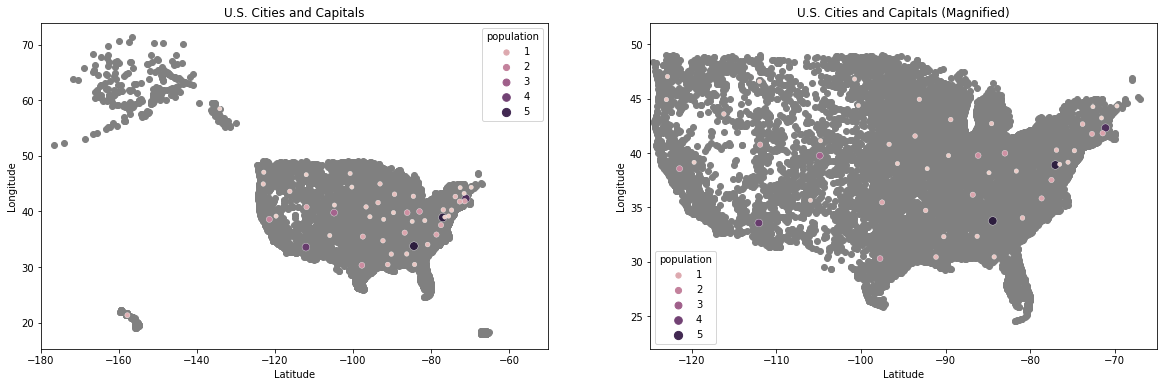

In [3]:
print('Description of U.S. Cities Dataset:')
display(us_cities.describe())

print('Mapped Out:')
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.scatter(us_cities['long'], us_cities['lat'], c='#808080')
sn.scatterplot(data=capitals, x='long', y='lat', ax=ax1, hue='population', size='population')

ax2.scatter(us_cities['long'], us_cities['lat'], c='#808080')
sn.scatterplot(data=capitals, x='long', y='lat', ax=ax2, hue='population', size='population')
#sn.color_palette("viridis", as_cmap=True)

ax1.set_xlim([-180, -50])
ax2.set_xlim([-125, -65])
ax2.set_ylim(22, 52)

ax1.set_xlabel('Latitude'); ax1.set_ylabel('Longitude');
ax2.set_xlabel('Latitude'); ax2.set_ylabel('Longitude');

ax1.title.set_text('U.S. Cities and Capitals')
ax2.title.set_text('U.S. Cities and Capitals (Magnified)')

plt.show()


**INTERPRETATION:** The description of the full dataset shows us that the minimum population of a 'city' is one person.  The mean population of a city falls somewhere above the third quartile, and 67% of our cities are incorporated.

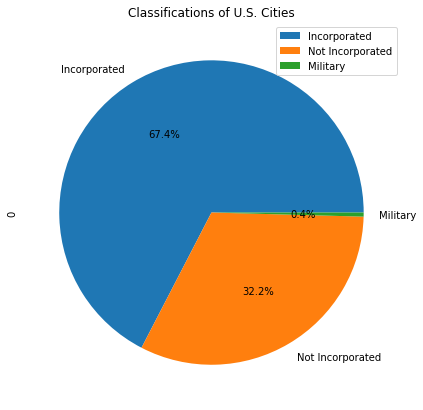

In [4]:
#All capitals and military bases are incorporated
labels = ['Incorporated', 'Not Incorporated', 'Military']
sizes = us_cities[['incorporated','military']].value_counts()
sizes = sizes.to_frame()
sizes.plot.pie(labels=labels, subplots=True, autopct='%1.1f%%', figsize=(10, 7))
_ = plt.title('Classifications of U.S. Cities')

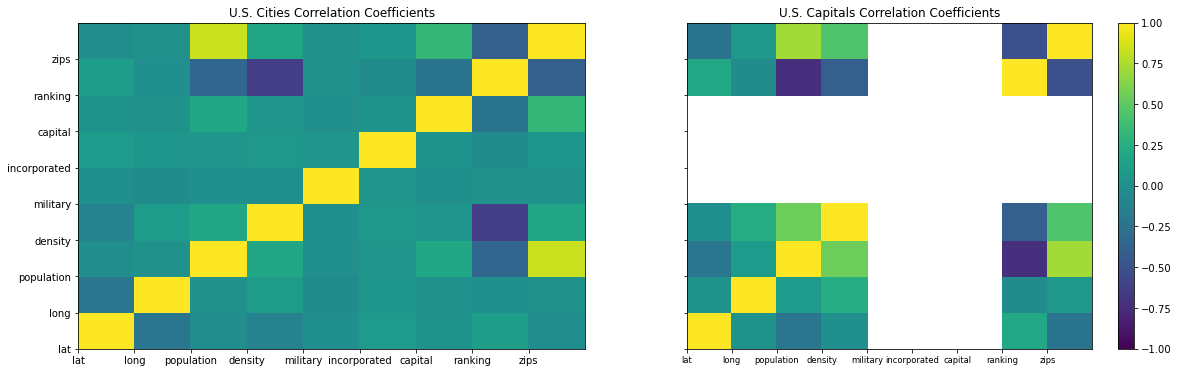

Correlation Matrix, All U.S. Cities:


,lat,long,population,density,military,incorporated,capital,ranking,zips
lat,1.000000,-0.215354,-0.016597,-0.110061,-0.009581,0.092169,0.008726,0.108250,-0.030217
long,-0.215354,1.000000,0.000170,0.097152,-0.034455,0.049121,0.000463,-0.013467,0.006120
population,-0.016597,0.000170,1.000000,0.187883,-0.004031,0.044540,0.194222,-0.339824,0.840090
density,-0.110061,0.097152,0.187883,1.000000,-0.008359,0.055030,0.041689,-0.633011,0.172560
military,-0.009581,-0.034455,-0.004031,-0.008359,1.000000,0.045228,-0.003399,0.005616,0.002319
incorporated,0.092169,0.049121,0.044540,0.055030,0.045228,1.000000,0.035639,-0.036995,0.047268
capital,0.008726,0.000463,0.194222,0.041689,-0.003399,0.035639,1.000000,-0.228524,0.324285
ranking,0.108250,-0.013467,-0.339824,-0.633011,0.005616,-0.036995,-0.228524,1.000000,-0.393716
zips,-0.030217,0.006120,0.840090,0.172560,0.002319,0.047268,0.324285,-0.393716,1.000000


Correlation Matrix, All U.S. Capitals:


,lat,long,population,density,military,incorporated,capital,ranking,zips
lat,1.000000,0.007915,-0.217229,-0.014718,NaN,NaN,NaN,0.201016,-0.229029
long,0.007915,1.000000,0.089589,0.238756,NaN,NaN,NaN,-0.036459,0.060839
population,-0.217229,0.089589,1.000000,0.551242,NaN,NaN,NaN,-0.721237,0.724139
density,-0.014718,0.238756,0.551242,1.000000,NaN,NaN,NaN,-0.399153,0.442941
military,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
incorporated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ranking,0.201016,-0.036459,-0.721237,-0.399153,NaN,NaN,NaN,1.000000,-0.509412
zips,-0.229029,0.060839,0.724139,0.442941,NaN,NaN,NaN,-0.509412,1.000000


In [5]:
corr = us_cities.corr()
c_corr = capitals.corr()
i_corr = incorp.corr()

fig2, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 6))

heatmap = ax1.pcolor(corr, vmin=-1, vmax=1)
heatmap = ax2.pcolor(c_corr, vmin=-1, vmax=1)
plt.colorbar(heatmap)

ax1.title.set_text('U.S. Cities Correlation Coefficients')
ax2.title.set_text('U.S. Capitals Correlation Coefficients')

labels=list(corr.index)
ticks = list(range(len(labels)))

_ = plt.xticks(ticks=ticks, labels=labels, size='small', stretch=150)
_ = plt.yticks(ticks=ticks, labels=labels, size='small')
plt.show()

print('Correlation Matrix, All U.S. Cities:')
display(corr)

print('Correlation Matrix, All U.S. Capitals:')
display(c_corr)

**INTERPRETATION:** From the outset, we see that the variables correlating most with *population* are (number of) *zips*, *ranking*, *capital*, and *density*. *Ranking* correlates most with *density*, *zips*, *population*, and *capital*. The correlation between population and number of ZIP codes makes sense, intuitively and seems to be a redundancy for the most part. 

The correlation matrix for the *capitals* subset, most notably, has missing rows and columns which indicates that there is no variation for those variables. In other words, all U.S. capitals are incorporated and none of them are military bases or forts (luckily this is of little surprise).

In [6]:
print("'ranking' Value Counts, for Military Bases:")
query = us_cities.loc[us_cities['military']==1]
display(pd.DataFrame(query['ranking'].value_counts()))

print("'ranking' Value Counts, for Capitals:")
display(pd.DataFrame(capitals['ranking'].value_counts()))

print("'ranking' Value Counts, for All Cities:")
display(pd.DataFrame(us_cities['ranking'].value_counts()))

query = us_cities.loc[us_cities['ranking']==1]
display(query.head(10))

'ranking' Value Counts, for Military Bases:


,ranking
3,78
2,4


'ranking' Value Counts, for Capitals:


,ranking
2,36
1,14
3,1


'ranking' Value Counts, for All Cities:


,ranking
3,17776
2,1269
1,50


,city,state_id,state,county,lat,long,population,density,military,incorporated,capital,timezone,ranking,zips
0,New York,NY,New York,New York,40.6943,-73.9249,18713220,10715,0,1,0,New_York,1,309
1,Los Angeles,CA,California,Los Angeles,34.1139,-118.4068,12750807,3276,0,1,0,Los_Angeles,1,196
2,Chicago,IL,Illinois,Cook,41.8373,-87.6862,8604203,4574,0,1,0,Chicago,1,85
3,Miami,FL,Florida,Miami-Dade,25.7839,-80.2102,6445545,5019,0,1,0,New_York,1,30
4,Dallas,TX,Texas,Dallas,32.7936,-96.7662,5743938,1526,0,1,0,Chicago,1,107
5,Philadelphia,PA,Pennsylvania,Philadelphia,40.0077,-75.1339,5649300,4554,0,1,0,New_York,1,86
6,Houston,TX,Texas,Harris,29.7863,-95.3889,5464251,1399,0,1,0,Chicago,1,181
7,Atlanta,GA,Georgia,Fulton,33.7627,-84.4224,5449398,1441,0,1,1,New_York,1,56
8,Washington,DC,District of Columbia,District of Columbia,38.9047,-77.0163,5379184,4457,0,1,1,New_York,1,292
9,Boston,MA,Massachusetts,Suffolk,42.3188,-71.0846,4688346,5532,0,1,1,New_York,1,53


**INTERPRETATION:** It appears then, that the best quantitive indicators for *ranking* are *population* and *density*. This likely shows that *ranking* prioritizes cities by historical and cultural influence, which otherwise falls outside of the scope of our datasets. Capitals tend to rank higher, it seems, because they are more likely to have higher populations, densities and some form of cultural significance--Philadelphia and Boston, for example, qualify in each of these cases.

Let's try reducing our data into a set of incorporated cities and see if a narrower set will improve correlations:

In [7]:
print('Changes in Correlation, Incorporated Cities Only:')
display(pd.DataFrame(corr - i_corr))
print('Number of cities within subset:', len(incorp), '\n')

mask = incorp['population'] > 2500
i_funnel = incorp.loc[mask]

print('Changes in Correlation, Incorporated Cities with Populations > 2500:')

display(corr - i_funnel.corr())
print('Number of cities within subset:', len(i_funnel))

Changes in Correlation, Incorporated Cities Only:


,lat,long,population,density,military,incorporated,capital,ranking,zips
lat,0.000000,0.037008,0.007933,-0.063084,0.009162,NaN,0.001312,0.024813,0.014269
long,0.037008,0.000000,0.004743,0.031648,0.017560,NaN,0.002288,-0.022410,0.010798
population,0.007933,0.004743,0.000000,-0.020270,0.002029,NaN,0.001192,0.043834,-0.002556
density,-0.063084,0.031648,-0.020270,0.000000,0.004218,NaN,-0.004355,-0.040257,-0.017491
military,0.009162,0.017560,0.002029,0.004218,0.000000,NaN,0.001620,-0.002773,0.002136
incorporated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capital,0.001312,0.002288,0.001192,-0.004355,0.001620,NaN,0.000000,0.032855,-0.000577
ranking,0.024813,-0.022410,0.043834,-0.040257,-0.002773,NaN,0.032855,0.000000,0.051527
zips,0.014269,0.010798,-0.002556,-0.017491,0.002136,NaN,-0.000577,0.051527,0.000000


Number of cities within subset: 12952 

Changes in Correlation, Incorporated Cities with Populations > 2500:


,lat,long,population,density,military,incorporated,capital,ranking,zips
lat,0.000000,-0.140211,0.005135,-0.130538,-0.002660,NaN,-0.014777,0.051531,0.013632
long,-0.140211,0.000000,0.010309,0.063111,0.027374,NaN,0.005366,-0.053341,0.020722
population,0.005135,0.010309,0.000000,-0.011205,0.008260,NaN,0.007428,0.050187,-0.001901
density,-0.130538,0.063111,-0.011205,0.000000,0.018051,NaN,0.017084,-0.096039,0.006067
military,-0.002660,0.027374,0.008260,0.018051,0.000000,NaN,0.006001,-0.016465,0.010902
incorporated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capital,-0.014777,0.005366,0.007428,0.017084,0.006001,NaN,0.000000,0.036428,0.005288
ranking,0.051531,-0.053341,0.050187,-0.096039,-0.016465,NaN,0.036428,0.000000,0.056132
zips,0.013632,0.020722,-0.001901,0.006067,0.010902,NaN,0.005288,0.056132,0.000000


Number of cities within subset: 5530


**INTERPRETATION:** The reductions in size for each dataset are relatively costly, with rather small changes in correlation. This assessment, however, excludes categorical variables such as *state*, *county*, and *timezone*.

Next up, let's see if there are any noticeable trends for the subset of military bases:

In [8]:
m_corr = us_cities.loc[us_cities['military']==1].corr()

print('Correlation Matrix, Military Bases:')
display(m_corr)

Correlation Matrix, Military Bases:


,lat,long,population,density,military,incorporated,capital,ranking,zips
lat,1.000000,-0.031885,-0.136985,-0.230390,NaN,NaN,NaN,0.215967,-0.109362
long,-0.031885,1.000000,-0.010040,-0.046349,NaN,NaN,NaN,0.145512,-0.031211
population,-0.136985,-0.010040,1.000000,0.296911,NaN,NaN,NaN,-0.133724,0.149523
density,-0.230390,-0.046349,0.296911,1.000000,NaN,NaN,NaN,-0.886168,0.018367
military,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
incorporated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ranking,0.215967,0.145512,-0.133724,-0.886168,NaN,NaN,NaN,1.000000,0.045041
zips,-0.109362,-0.031211,0.149523,0.018367,NaN,NaN,NaN,0.045041,1.000000


**INTERPRETATION:** When it comes to military bases, the number of ZIP codes and ranking lose a fair bit of correlation with population. On the other hand, density and latitude coordinates improve, likely due to less variance.

In [9]:
capitals['timezone'].value_counts()

New_York                20
Chicago                 16
Denver                   5
Los_Angeles              4
Honolulu                 1
Juneau                   1
Phoenix                  1
Boise                    1
Indiana/Indianapolis     1
Detroit                  1
Name: timezone, dtype: int64

# Predicting Populations via Linear Regression

Now that we have identified the most important correlations in the dataset, during the explorational analysis, what combination yields the best linear regression?

In [10]:
cities_ols = sm.ols(formula="population ~ zips + capital", data=us_cities).fit() #R^2=0.713, best F-stat

# cities_ols = sm.ols(formula="population ~ zips + capital + density", data=us_cities).fit() #R^2=0.714
# cities_ols = sm.ols(formula="population ~ zips", data=us_cities).fit() #R^2=0.706

print('Population ~ zips + capital:')
display(cities_ols.summary())

Population ~ zips + capital:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             population   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                 2.367e+04
Date:                Sun, 25 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:24:39   Log-Likelihood:            -2.5101e+05
No. Observations:               19095   AIC:                         5.020e+05
Df Residuals:                   19092   BIC:                         5.020e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.949e+04    950.817    -52.052      0.000   -5.14e+04   -4.76e+04
zips        4.006e+04    189.192    211.729      0.000    3.97e+04    4.04e+04
capital     -3.91e+05   1.83e+04    -21.308      0.000   -4.27e+05   -3.55e+05
==============================================================================
Omnibus:                    36940.279   Durbin-Watson:                   1.402
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1199782700.942
Skew:                          14.076   Prob(JB):                         0.00
Kurtosis:                    1230.674   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Classification with Categorical Variables: Decision Trees

The best correlations we have for predicting a city's population are number of ZIPs, density, ranking, and if it is a capital. With a multi-linear regression, we have found a relatively effective model that relies primarily on the number of ZIPs. However, until this point, we have not explored the relationships the dataset has with respect to categorical variables *state*, *timezone*, or *county*.

Decision trees can be effective classifiers when it comes to predicting categorical variables. To use the other, string-type categorical variables, we will have to represent each string value as a unique integer. With this classification method, we want to identify which combinations of variables are best for accurately predicting (a) the state that a city is in and (b) the county a city is in for a specific state. For the second case, we will use California as the study since it should offer a larger sample size with training and testing. State and county lines have important effects on a city's population, density, and even socio-political factors that might play into *ranking*. Using classification, we can see which variables correlate with those state/county lines.

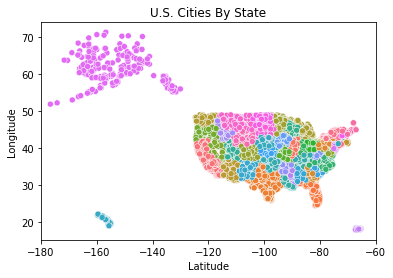

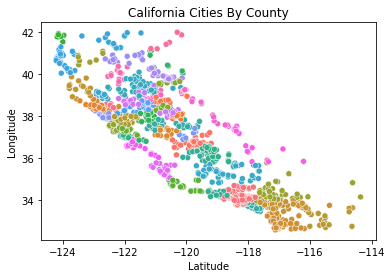

In [11]:
fig3 = sn.scatterplot(data=us_cities, x='long', y='lat', hue='state',legend=False)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
_ = plt.xlim([-180, -60])
_ = plt.title('U.S. Cities By State')
plt.show()

mask = us_cities['state_id'] == 'CA'
CA = us_cities.loc[mask].sample(frac=1)

sn.scatterplot(data=CA, x='long', y='lat', hue='county', legend=False)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
_ = plt.title('California Cities By County')
plt.show()

Predicting a City's State:
Accuracy on training data=  1.0
Accuracy on test data=  0.9709886887306242
Decision Tree: State with Latitude and Longitude


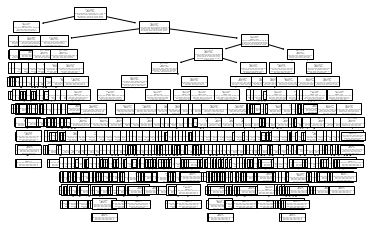

<Figure size 1440x1440 with 0 Axes>

In [12]:
as_num = lambda string : {_:i for i,_ in enumerate(us_cities[string].unique())}

# State Prediction Accuracy (0.5 test split):
# timezone -> [0.303,0.309]
# ranking -> [0.08,0.08]
# [lat,long] -> [1.0,0.97]
# [timezone,ranking] -> [0.305,0.311]
# ['lat','timezone','density']  -> [1.0,0.587]


features = ['lat','long'] 
X = us_cities[features]
# X['timezone'] = X['timezone'].map(as_num('timezone'))
# X['county'] = X['county'].map(as_num('county'))
X = X.values

y = us_cities['state'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53, test_size=0.5)

decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(X_train, y_train)

print("Predicting a City's State:")
y_pred_t = decisionTree.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_t))

y_pred = decisionTree.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

print('Decision Tree: State with Latitude and Longitude')
_ = tree.plot_tree(decisionTree)
_ = plt.figure(figsize=(20,20))
plt.show()

**INTERPRETATION:** It makes plenty of intuitive sense for latitude and longitude to be the best predictors of a given city's state. Interestingly, however, the *timezone* variable can act as a quasi-longitude coordinate, just more discretized. So, using the latitude and timezone of a city can yield about 99.4% and 55.3% accuracy for the training and test data respectively.

In [13]:
features = ['county','timezone'] 
X = us_cities[features]
X['timezone'] = X['timezone'].map(as_num('timezone'))
X['county'] = X['county'].map(as_num('county'))
X = X.values

y = us_cities['state'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53, test_size=0.5)

decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(X_train, y_train)

print("Predicting a City's State with Timezone and County:")
y_pred_t = decisionTree.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_t))

y_pred = decisionTree.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Predicting a City's State with Timezone and County:
Accuracy on training data=  0.8463391641353305
Accuracy on test data=  0.7791160452450775


C:\Users\arbur\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\arbur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Timezone and county, being geographic/spacial variables, also do relatively well to predict a city's state. Other combinations of variables, however don't seem to compete with the two models shown. **Let's double check this with California.** Perhaps a subset will have more options than using spatial variables.

Predicting a City's State with Timezone and County:
Accuracy on training data=  1.0
Accuracy on test data=  0.8612903225806452 

Decision Tree: Counties with Latitude and Longitude


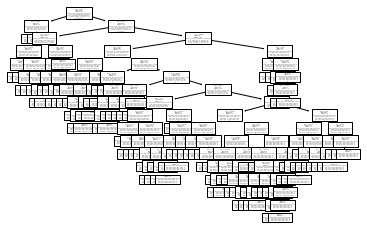

<Figure size 1440x1440 with 0 Axes>

Predicting a City's State with Population, 'incorporated' and Latitude:
Accuracy on training data=  1.0
Accuracy on test data=  0.38225806451612904


In [14]:
as_num = lambda string : {_:i for i,_ in enumerate(CA[string].unique())}

features = ['lat','long'] 
X = CA[features]
# X['county'] = X['county'].map(as_num('county'))
X = X.values

y = CA['county'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53, test_size=0.5)

decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(X_train, y_train)

print("Predicting a City's State with Timezone and County:")
y_pred_t = decisionTree.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_t))

y_pred = decisionTree.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred),'\n')

print('Decision Tree: Counties with Latitude and Longitude')
_ = tree.plot_tree(decisionTree)
_ = plt.figure(figsize=(20,20))
plt.show()


features = ['population','incorporated','lat'] 
X = CA[features]
# X['county'] = X['county'].map(as_num('county'))
X = X.values

y = CA['county'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53, test_size=0.5)

decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(X_train, y_train)

print("Predicting a City's State with Population, 'incorporated' and Latitude:")
y_pred_t = decisionTree.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_t))

y_pred = decisionTree.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

**INTERPRETATION:** Here, we see a similar effectivity for classifying a California city's county, but there is a noticeable dip in accuracy. Perhaps there is a higher likelihood for overlap in coordinates. We also see that all the other variables produce ~0% accuracies on their training sets without some spatial coordinate.

# Image Processing

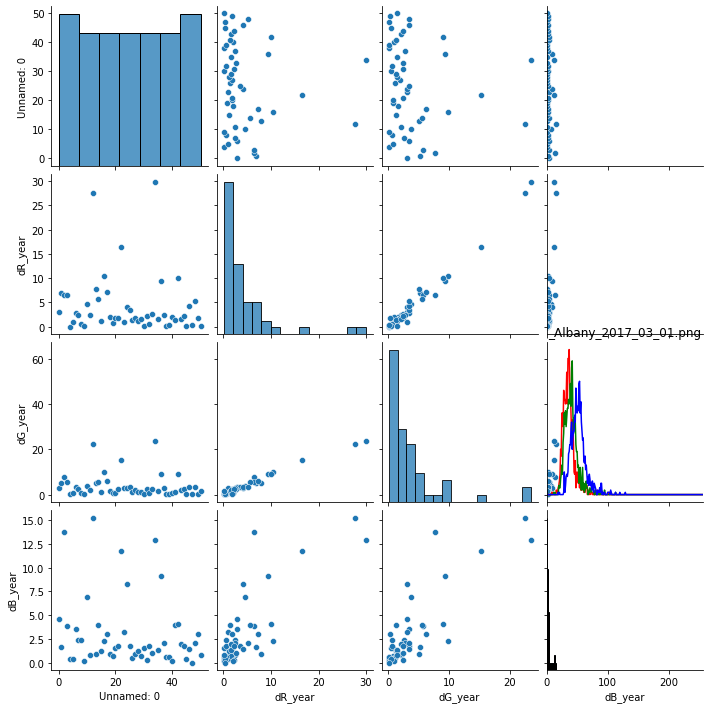

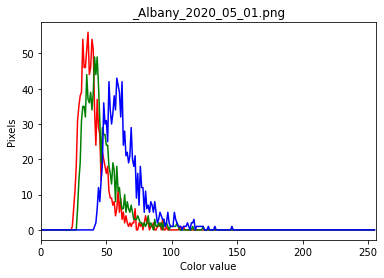

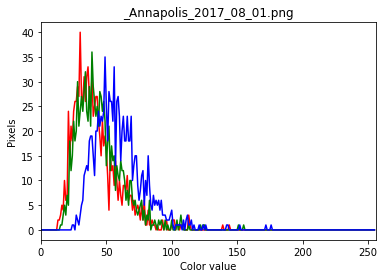

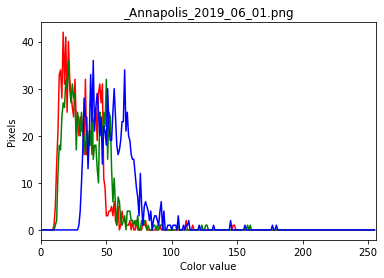

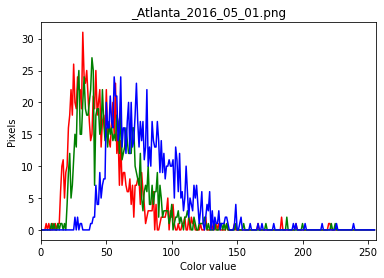

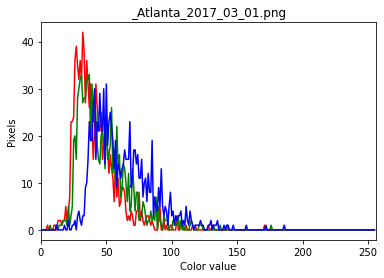

,Unnamed: 0,Cities,dR_year,dG_year,dB_year,bef_hist,aft_hist
0,0,Albany,2.944015,3.024274,4.557343,[[[ 39 44 58]\n [ 66 75 92]\n [ 56 67 ...,[[[ 32 36 45]\n [ 55 61 73]\n [ 49 56 ...
1,1,Annapolis,6.939145,5.255982,1.670887,[[[13 14 32]\n [15 17 34]\n [17 19 37]\n .....,[[[19 20 32]\n [19 20 34]\n [18 22 40]\n .....
2,2,Atlanta,6.446456,7.629570,13.730047,[[[ 43 50 66]\n [ 33 37 49]\n [ 25 27 ...,[[[ 35 43 70]\n [ 27 32 56]\n [ 25 29 ...
3,3,Augusta,6.526476,5.745234,3.900349,[[[ 26 34 61]\n [ 24 31 55]\n [ 8 12 ...,[[[ 28 36 61]\n [ 28 36 61]\n [ 20 25 ...
4,4,Austin,0.034706,0.119239,0.373687,[[[ 37 42 66]\n [ 30 37 59]\n [ 18 22 ...,[[[ 36 43 69]\n [ 34 41 65]\n [ 22 27 ...
5,5,Baton Rouge,0.912382,0.684255,0.390161,[[[ 86 102 131]\n [ 83 101 131]\n [ 96 115 1...,[[[ 92 109 141]\n [ 92 109 140]\n [109 127 1...
6,6,Bismarck,2.780565,3.384318,3.595980,[[[40 50 77]\n [32 42 69]\n [29 42 71]\n .....,[[[30 37 60]\n [27 33 54]\n [26 35 59]\n .....
7,7,Boise,2.386804,2.653716,2.348245,[[[ 55 65 90]\n [ 67 78 106]\n [ 82 95 1...,[[[ 54 63 87]\n [ 64 74 104]\n [ 80 91 1...
8,8,Boston,0.606836,0.657842,2.404767,[[[ 35 38 48]\n [ 51 57 73]\n [ 84 92 1...,[[[ 30 33 47]\n [ 43 47 67]\n [ 62 69 ...
9,9,Carson City,0.091683,0.066417,0.223269,[[[ 61 73 99]\n [ 64 76 103]\n [ 61 70 ...,[[[ 57 70 99]\n [ 59 73 102]\n [ 59 71 ...


In [118]:
#TODO - Process the RGB hists and intensities with a function, going through 
import sys
import skimage
import skimage.io
import skimage.viewer
from skimage import data
from skimage.viewer import ImageViewer
from matplotlib import pyplot as plt
import re
import seaborn as sns



img_list = os.listdir('images/')[1:]
for img_name in img_list:
    img = Image.open('images/'+img_name)
    #iterate through list and attach read image to capitals dataframe
    image = skimage.io.imread('images/'+img_name)
    

img_list


colors_hist = pd.read_csv("color_histograms.csv")

colors_hist.describe()
bef = colors_hist['bef_hist'].values
aft = colors_hist['aft_hist'].values
sn.pairplot(colors_hist)

# plt.hist(data = colors_hist, x = 'num_var')

df_col = ['city', 'bef', 'aft']
df = pd.DataFrame(columns = df_col)
i = 0

for img_name in img_list[:6]:
    img = Image.open('images/'+img_name)
    #iterate through list and attach read image to capitals dataframe
    image = skimage.io.imread('images/'+img_name)
    colors = ("r", "g", "b")
    channel_ids = (0, 1, 2)
    

    # create the histogram plot, with three lines, one for
    # each color
    plt.xlim([0, 256])
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            image[:, :, channel_id], bins=256, range=(0, 256)
        )
        plt.plot(bin_edges[0:-1], histogram, color=c)
    
    i+=1
    
        
    plt.title(img_name)
    plt.xlabel("Color value")
    plt.ylabel("Pixels")
    plt.show()
colors_hist

# Peer Feedback